In [6]:
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import rc
from matplotlib.ticker import MultipleLocator,AutoMinorLocator
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerPatch
from matplotlib.lines import Line2D

from astropy import units as u
from astropy.time import Time
import copy
from matplotlib.legend_handler import HandlerTuple
from matplotlib.container import ErrorbarContainer
from matplotlib.collections import LineCollection

from astropy.io import ascii
from astropy.table import Table, Column, vstack, unique
import numpy as np
import re
import matplotlib.cm as cm
import sys
import os
import json
import requests
import base64
from io import BytesIO

from redback.model_library import all_models_dict
import redback
from redback.simulate_transients import SimulateOpticalTransient

def ccolor(r,g,b):
    return((r/255.,g/255.,b/255., 1.0))

black=ccolor(0,0,0)
red=ccolor(255,0,0)
blue=ccolor(10,0,255)
green=ccolor(12,83,0)
magenta=ccolor(204,0,204)
goldenrod=ccolor(239,139,8)
orange=ccolor(204,102,0)

# Plotting parameters and functions
pad = 0.25
figsize = 10.0
rc('font',**{'family':'serif','serif':['Times'],'size':6.0*figsize})
rc('text', usetex=True, color=black)

def setup_plot(size=[1.8, 1.5]):

    fig, ax = plt.subplots()
    for i in ax.spines.keys(): ax.spines[i].set_linewidth(0.6*figsize)
    fig.set_size_inches(size[0]*figsize, size[1]*figsize)

    return(fig, ax)

def setup_ticks(ax):

    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())

    ax.tick_params(direction='in', length=1.5*figsize,
            width=0.5*figsize, which='major', axis='both', colors=black,
            pad=0.3*figsize, top=True, bottom=True, left=True, right=True)
    ax.tick_params(direction='in', length=0.75*figsize,
            width=0.5*figsize, which='minor', axis='both', colors=black,
            pad=0.3*figsize, top=True, bottom=True, left=True, right=True)

def setup_axis_titles(ax, xtitle, ytitle):

        ax.set_xlabel(xtitle, labelpad=pad)
        ax.set_ylabel(ytitle, labelpad=pad)

def get_treasuremap_data(outfile, event_name):

    if os.path.exists(outfile):
        return(None)

    dirname, basefile = os.path.split(outfile)

    if not os.path.exists(dirname):
        os.makedirs(dirname)

    BASE = "https://treasuremap.space/api/v1"
    TARGET = "pointings"

    if 'TREASURE_MAP_API_TOKEN' not in os.environ.keys():
        raise Exception('Add TREASURE_MAP_API_TOKEN to environment variables')
    else:
        API_TOKEN = os.environ['TREASURE_MAP_API_TOKEN']
    
    json_params = {
        "api_token":API_TOKEN,
        "status":"completed",
        "graceid":"S251112cm"
    }
    
    url = "{}/{}".format(BASE, TARGET)
    
    r = requests.get(url=url, json=json_params)
    
    data = json.loads(r.text)
    
    with open(outfile,'w') as f:
        for dat in data:
            t = Time(dat['time'])
            depth = dat['depth']
            cw = dat['central_wave']
            inst = dat['instrumentid']
    
            band=''
    
            if int(inst)==38:
                inst='DECam'
            elif int(inst)==78:
                inst='MeerLICHT'
            elif int(inst)==79:
                inst='BlackGEM'
            elif int(inst)==11:
                inst='CSS'
    
            if float(cw)==4730.5:
                band = 'g'
            elif float(cw)==7836.21:
                band = 'i'
            elif float(cw)==5800.0:
                band = 'q'
            elif float(cw)==7000.0:
                band = 'V'
    
            if not band:
                raise Exception(f'Unknown cw {cw}, inst {inst}')
    
    
            f.write(f'{t.mjd} {band} {depth} {inst} \n')

def get_event_data(event_name):
    url = f'https://gracedb.ligo.org/api/superevents/{event_name}/files/{event_name}-update.json'

    r = requests.get(url)
    if r.status_code==200:
        data = json.loads(r.text)
        return(data)


def get_event_distance(record):

    # Parse sky map
    if 'skymap' in record['event'].keys():
        event_data = record.get('event')
        skymap_bytes = event_data.get('skymap')
        if isinstance(skymap_bytes, str):
            skymap_bytes = base64.b64decode(skymap_bytes)

    skymap = Table.read(BytesIO(skymap_bytes))

    dist_mean = skymap.meta.get('DISTMEAN')

    return(dist_mean)

def is_number(val):
    try:
        float(val)
        return(True)
    except:
        return(False)

In [7]:
event_name='S251112cm'

pointing_file=f'data/limits/{event_name}_pointings.txt'
get_treasuremap_data(pointing_file, event_name)
event_data = get_event_data(event_name)

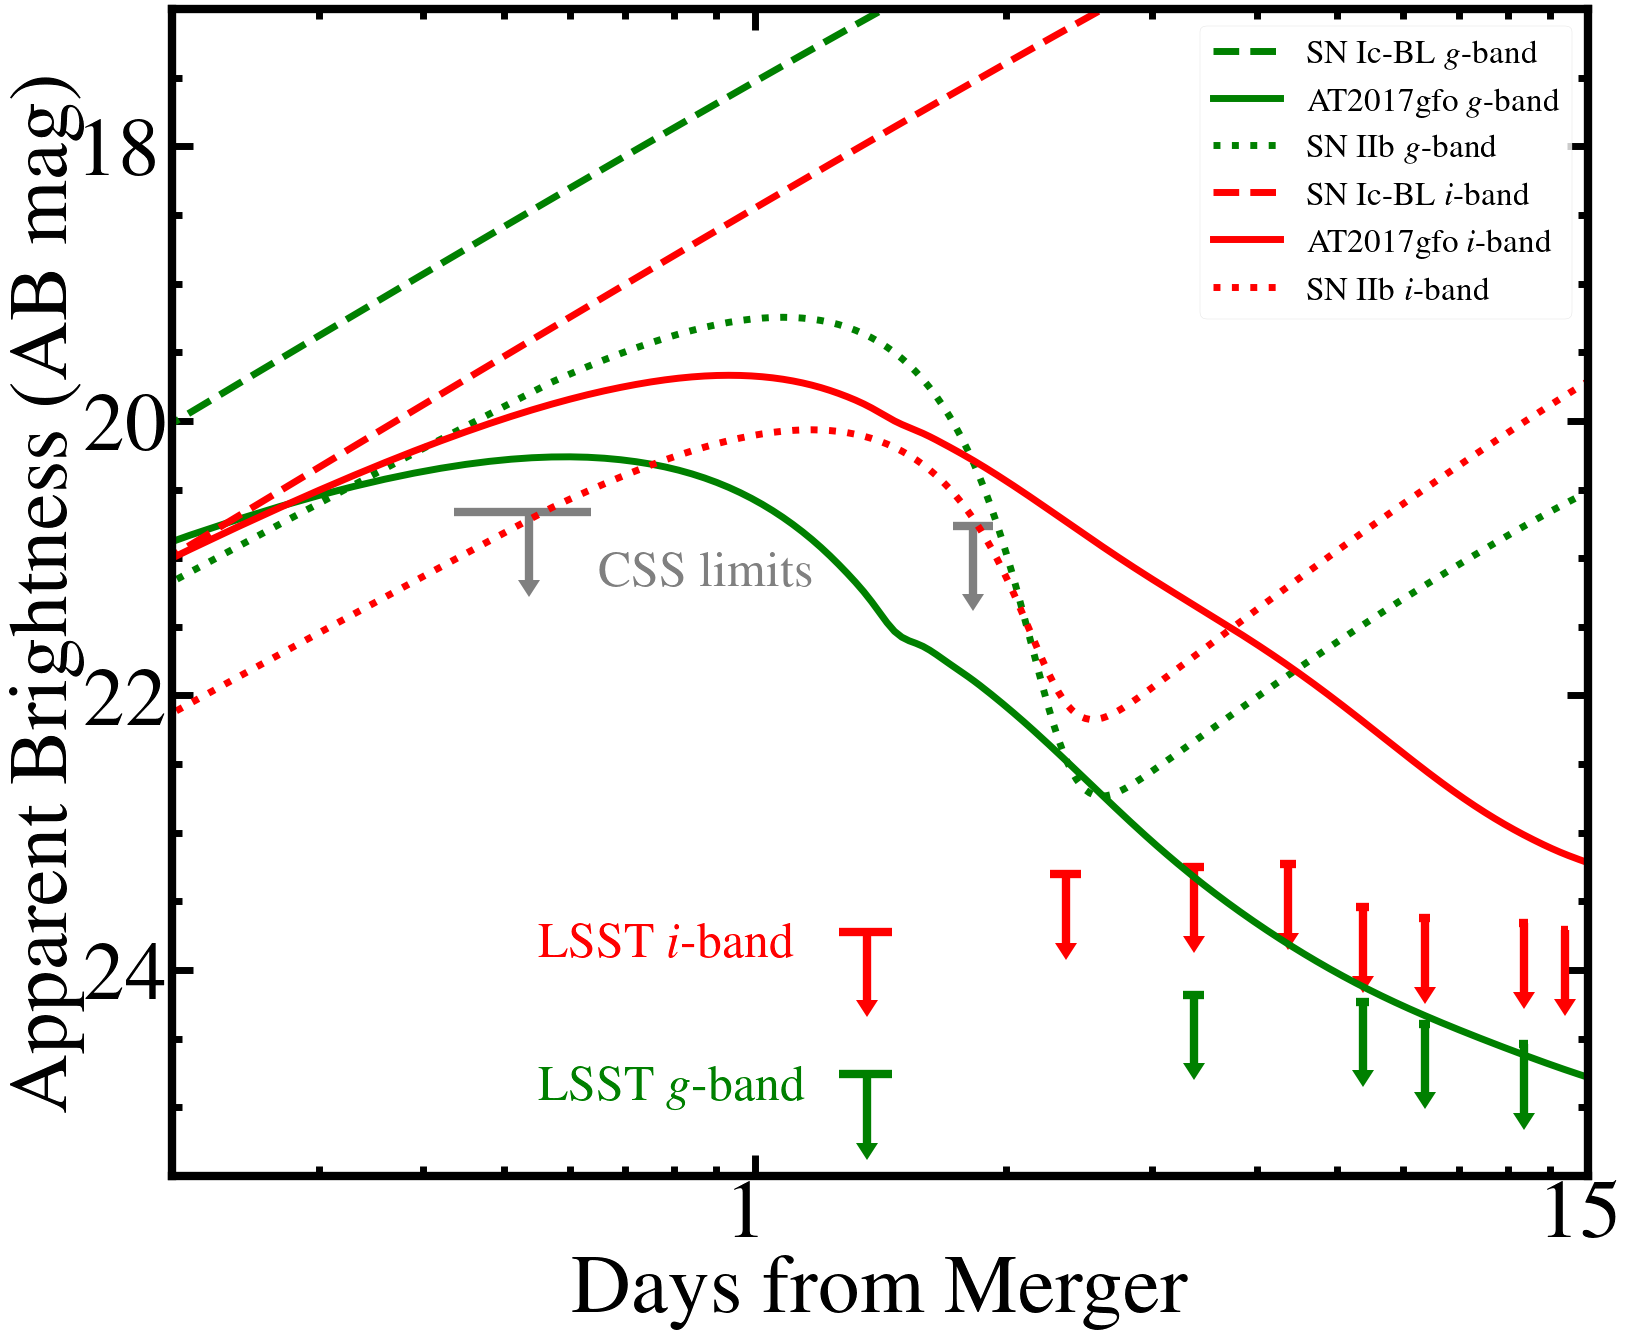

In [66]:
# Set up periodogram plot parameters
rc('font',**{'family':'serif','serif':['Times'],'size':6.0*figsize})
rc('text', usetex=True, color=black)
fig, ax = setup_plot(size=[1.8, 1.5])

# Reference time and distance modulus of event from Update avro packet
ref_date = Time(event_data['event']['time'])
ref_dist = get_event_distance(event_data)
ref_dm = 5*np.log10(ref_dist)+25.0

setup_ticks(ax)
setup_axis_titles(ax,'Days from Merger','Apparent Brightness (AB mag)')

table = Table.read(pointing_file, format='ascii')

ax.set_ylim([25.5, 17])
ax.set_xlim([0.2, 10])
ax.set_xscale('log')

max_time = 15.0

mask = table['col4']=='CSS'
table = table[mask]
table['col1']=table['col1']-ref_date.mjd

# Add in CSS limits
for i in np.arange(int(max_time)):
    mask = (table['col1']>i) & (table['col1']<i+1)

    time = np.mean(table['col1'][mask])
    depth = np.mean(table['col3'][mask])

    ax.errorbar(time, depth, yerr=0.5, lolims=True, marker='_', color='gray', markersize=64, linewidth=6, capsize=8, label=None)
    ax.hlines(depth, time-0.1, time+0.1, color='gray', linewidth=6)

# Add Rubin limits
table = Table.read('data/limits/rubin_limits.txt', format='ascii')
for row in table:
    date = Time(row['date']).mjd-ref_date.mjd

    gdepth = row['glim']
    idepth = row['ilim']

    if is_number(gdepth):
        gdepth=float(gdepth)
        
        ax.errorbar(date, gdepth, yerr=0.5, lolims=True, marker='_', color='green', markersize=64, linewidth=6, capsize=8, label=None)
        ax.hlines(gdepth, date-0.1, date+0.1, color='green', linewidth=6)
        
    if is_number(idepth):
        idepth=float(idepth)

        ax.errorbar(date, idepth, yerr=0.5, lolims=True, marker='_', color='red', markersize=64, linewidth=6, capsize=8, label=None)
        ax.hlines(idepth, date-0.1, date+0.1, color='red', linewidth=6)


# Add in models from redback
time_array = np.linspace(0, 2*max_time, 1000)
dummy_redshift = 0.01
from astropy.cosmology import Planck15 as cosmo
dummy_distance = cosmo.luminosity_distance(dummy_redshift).to(u.Mpc).value
dummy_dm = 5 * np.log10(dummy_distance) + 25.0

colors={'g':'green','i':'red'}

# Generate models

for filt in ['g','i']:
    # See: https://iopscience.iop.org/article/10.3847/1538-4357/aafa13/pdf
    model_params = {
    'output_format': 'magnitude',
    'redshift': dummy_redshift,
    'f_nickel': np.float64(0.57),
     'p0': np.float64(6.41),
     'bp': np.float64(10**(0.22)),
     'mass_ns': 1.82,
     'theta_pb': 1.5357176532330916,
     'mej': np.float64(10**(0.22)),
     'vej': np.float64(12100),
     'kappa': 0.17,
     'kappa_gamma': np.float64(10**(-1.19)),
     'temperature_floor': np.float64(4550)
    }

    mags = all_models_dict['magnetar_nickel'](time_array, **model_params, bands=['lsst'+filt])
    mags = mags-dummy_dm

    ax.plot(time_array, mags + ref_dm, color=colors[filt], linewidth=5, linestyle='dashed', label='SN Ic-BL '+rf'${filt}$-band')

    # See: https://iopscience.iop.org/article/10.3847/2041-8213/aa9c84/pdf
    model_params = {
    'output_format': 'magnitude',
    'redshift': dummy_redshift,
    'mej_1': 0.020,
    'vej_1': 0.256,
    'kappa_1': 0.5,
    'temperature_floor_1': 3983,
    'mej_2': 0.047,
    'vej_2': 0.152,
    'kappa_2': 3.0,
    'temperature_floor_2': 1308,
    'mej_3': 0.011,
    'vej_3': 0.137,
    'kappa_3': 10.0,
    'temperature_floor_3': 3745,
    }

    mags = all_models_dict['three_component_kilonova_model'](time_array, **model_params, bands=['lsst'+filt])
    mags = mags-dummy_dm

    ax.plot(time_array, mags + ref_dm, color=colors[filt], linewidth=5, label='AT2017gfo '+rf'${filt}$-band')

    # See: https://arxiv.org/pdf/1611.06451
    model_params = {
        'output_format': 'magnitude',
        'redshift': 0.01,
        'log10_mass': np.log10(3.0e-2),
        'log10_radius': np.log10(3.0e12),
        'log10_energy': np.log10(1.0e51),
        'nn': 10.0,
        'delta': 1.0,
        'f_nickel': np.float64(0.1),
        'mej': np.float64(2.0),
        'vej': np.float64(8100),
        'kappa': 1.0,
        'kappa_gamma': np.float64(0.01),
        'temperature_floor': np.float64(3550)}

    mags = all_models_dict['shock_cooling_and_arnett'](time_array, **model_params, bands=['lsst'+filt])
    mags = mags-dummy_dm

    ax.plot(time_array, mags + ref_dm, color=colors[filt], linewidth=5, linestyle='dotted', label='SN IIb '+rf'${filt}$-band')

    

ax.text(0.65, 21.2, 'CSS limits', color='gray', fontsize=36)

ax.text(0.55, 23.9, 'LSST $i$-band', color='red', fontsize=36)
ax.text(0.55, 24.95, 'LSST $g$-band', color='green', fontsize=36)

ax.set_xticks([1,10])
ax.set_xticklabels(['1','15'])

plt.legend(fontsize=24)

plt.tight_layout()